## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [43]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [44]:
#importing environment class and creating an object of the same
from TCGame_Env1 import TicTacToe
env=TicTacToe()

In [45]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [46]:
print(Q_state(env.state))

x-x-x-x-x-x-x-x-x


In [47]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [48]:
print(valid_actions(env.state))

[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 3), (3, 5), (3, 7), (3, 9), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 1), (5, 3), (5, 5), (5, 7), (5, 9), (6, 1), (6, 3), (6, 5), (6, 7), (6, 9), (7, 1), (7, 3), (7, 5), (7, 7), (7, 9), (8, 1), (8, 3), (8, 5), (8, 7), (8, 9)]


In [49]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [50]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state,time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action
    




#### Tracking the state-action pairs for checking convergence - write your code here

In [51]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [52]:
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('1-x-x-2-x-x-x-x-x',(7,5)),('x-5-x-x-x-x-x-8-x',(8,3))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []


In [53]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [54]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [55]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [56]:
#Defining parameters for the experiment


EPISODES = 500000
                
LR = 0.01                   #learning rate
GAMMA = 0.91

threshold = 200       #every these many episodes, the states tracked will be saved
policy_threshold = 300    #every these many episodes, the Q-dict will be updated
max_epsilon=1.0
min_epsilon=0.001


### Q-update loop ---write your code here

In [57]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env=TicTacToe() #this will intialise the state and all for every episode
    curr_state=env.state
    final=False
    add_to_dict(curr_state)
    
    while final == False:
        curr_state_q=Q_state(curr_state)
        curr_action=epsilon_greedy(curr_state,episode)
        next_state,reward,final=env.step(curr_state,curr_action)
        next_state_q=Q_state(next_state)
        add_to_dict(next_state)
        
        if final == False:
            max_next = max(Q_dict[next_state_q],key=Q_dict[next_state_q].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_q][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_q][max_next])))
                                                      - Q_dict[curr_state_q][curr_action] ) 
        else:
            Q_dict[curr_state_q][curr_action] += LR * ((reward - Q_dict[curr_state_q][curr_action]))
        
        curr_state=next_state  # moving on to the next state
    
    #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')
#         print(episode) 

    if ((episode+1)% policy_threshold) == 0:  #every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')  
    
    
      
    
    

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

#### Check the Q-dictionary

In [58]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.1019449107784045,
              (0, 3): -1.1016390979278992,
              (0, 5): -1.1016315417194396,
              (0, 7): -1.1018478655160509,
              (0, 9): -1.101852416149248,
              (1, 1): -1.1019716688416563,
              (1, 3): -1.1026097545419369,
              (1, 5): -1.1023508806741096,
              (1, 7): -1.1015709376919043,
              (1, 9): -1.1017292202210465,
              (2, 1): -1.1023541714833893,
              (2, 3): -1.1016276652970431,
              (2, 5): -1.1020883612404209,
              (2, 7): -1.1015878121145566,
              (2, 9): -1.1016880228773729,
              (3, 1): -1.1021943711264917,
              (3, 3): -1.1017819182611936,
              (3, 5): -1.1018883987060764,
              (3, 7): -1.102007424584247,
              (3, 9): -1.1019947368343852,
              (4, 1): -1.101642006154942,
              (4, 3): -1.1019643998305348,
              (4, 

In [59]:
len(Q_dict)

959904

In [86]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
max(Q_dict['x-x-5-x-2-x-x-x-x'],key=Q_dict['x-x-5-x-2-x-x-x-x'].get)

(6, 9)

In [87]:
Q_dict['x-x-5-x-2-x-x-x-x']

{(0, 1): -0.2275191209750315,
 (0, 3): -0.12247897700103201,
 (0, 7): -0.1118574813479158,
 (0, 9): -0.119794295001032,
 (1, 1): -0.20184972733846174,
 (1, 3): -0.12070393463193202,
 (1, 7): -0.36964664267929837,
 (1, 9): -0.2646917525163591,
 (3, 1): -0.1856179249911955,
 (3, 3): -0.20094203828387072,
 (3, 7): -0.19750100959549982,
 (3, 9): -0.2036151282838707,
 (5, 1): -0.16864680292487189,
 (5, 3): -0.2036151282838707,
 (5, 7): -0.3172506453587115,
 (5, 9): -0.1957612507823835,
 (6, 1): -0.12247897700103201,
 (6, 3): -0.11891997154193203,
 (6, 7): -0.17383137616441327,
 (6, 9): -0.11184026519387072,
 (7, 1): -0.11361512828387071,
 (7, 3): -0.12247897700103201,
 (7, 7): -0.1992042327748707,
 (7, 9): -0.20387336375182444,
 (8, 1): -0.11361512828387071,
 (8, 3): -0.1295320393496578,
 (8, 7): -0.19021255379587454,
 (8, 9): -0.20469552927455967}

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(close=None, block=None)>

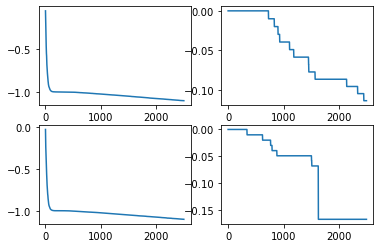

In [61]:
# Write the code for plotting the graphs for state-action pairs tracked

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['1-x-x-2-x-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['1-x-x-2-x-x-x-x-x'][(7,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-x-x-x-x-8-x'][(8,3)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-x-x-x-8-x'][(8,3)]))
plt.show

### Epsilon - decay check

In [20]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

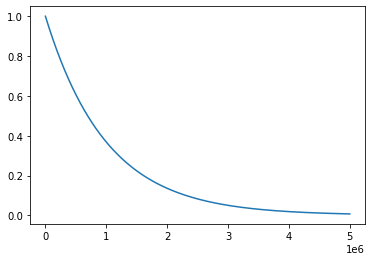

In [21]:
plt.plot(time, epsilon)
plt.show()

In [62]:
States_track['x-x-x-x-x-x-x-x-x'][(6,5)]

[-0.058519850599,
 -0.09561792499119551,
 -0.13994164535871148,
 -0.18209306240276912,
 -0.20638571635634448,
 -0.2299568541948447,
 -0.26769663034560237,
 -0.27501966404214634,
 -0.29655230500043056,
 -0.32427095093971664,
 -0.3827098590577118,
 -0.39499393286246337,
 -0.4360948095476122,
 -0.46909445704488656,
 -0.5001629701008008,
 -0.5198585434285785,
 -0.5341192248302064,
 -0.5524767862361891,
 -0.561382498190089,
 -0.5657686732081881,
 -0.5828791200667794,
 -0.6112160819257731,
 -0.6302703623502736,
 -0.6339676587267709,
 -0.6588339384859575,
 -0.6820109361808564,
 -0.6945409740716953,
 -0.6975955643309784,
 -0.7095115056900362,
 -0.7237483323007915,
 -0.7319532830831258,
 -0.7399145386222737,
 -0.7575833539554195,
 -0.7694641816814738,
 -0.7785482127611387,
 -0.7851255522939201,
 -0.7935924628825861,
 -0.7976999728712226,
 -0.8076146871060327,
 -0.8188730468740295,
 -0.8277500698084984,
 -0.8410572908002124,
 -0.8457780482061552,
 -0.8488470650468527,
 -0.8591155870957322,
 -0.8

In [63]:
States_track['1-x-x-2-x-x-x-x-x'][(7,5)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [64]:
States_track['x-x-x-x-x-x-x-x-x'][(1,9)]

[-0.029701,
 -0.09561792499119551,
 -0.1312541872310217,
 -0.1654862385499124,
 -0.22217864060085324,
 -0.23765728565289626,
 -0.26029962661171957,
 -0.30358678195042627,
 -0.32427095093971664,
 -0.33771795901601626,
 -0.39499393286246337,
 -0.40703355359850035,
 -0.41296321806251535,
 -0.4473165228376147,
 -0.45284335760923855,
 -0.4637317747928147,
 -0.4744035124744377,
 -0.4848628825761964,
 -0.5198585434285785,
 -0.5433902522560852,
 -0.561382498190089,
 -0.5657686732081881,
 -0.5744098766113452,
 -0.595268027321676,
 -0.6189528818954503,
 -0.6302703623502736,
 -0.6588339384859575,
 -0.6689669116789861,
 -0.6787989254352085,
 -0.6914555293653488,
 -0.7036134126007919,
 -0.7181393044595363,
 -0.7319532830831258,
 -0.7372874127497715,
 -0.750162943541547,
 -0.7551347009650703,
 -0.7694641816814738,
 -0.7785482127611387,
 -0.7872742967709809,
 -0.7976999728712226,
 -0.8037084859769744,
 -0.8076146871060327,
 -0.8151954360514534,
 -0.8188730468740295,
 -0.8345374043352651,
 -0.84105729

In [65]:
States_track['x-5-x-x-x-x-x-8-x'][(8,3)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
